In [30]:
import sys
import os

# Add the project root to sys.path (not src directly!)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.evaluation import calculate_rmse, calculate_precision_recall_at_k
from src.recommender import UserBasedCF, ItemBasedCF


In [32]:
user_item_matrix = pd.read_csv(
    r'C:\Users\PC\Desktop\collaborative-filtering-recommender\results\user_item_matrix.csv', 
    index_col='user_id_ml'
)
ubcf_model = UserBasedCF(min_common_items=5)
ubcf_model.fit(user_item_matrix)

ibcf_model = ItemBasedCF(min_common_users=5)
ibcf_model.fit(user_item_matrix)

In [33]:
test_ratings = pd.read_csv(r'C:\Users\PC\Desktop\collaborative-filtering-recommender\results\test_ratings.csv')
ubcf_results = pd.read_csv(r'C:\Users\PC\Desktop\collaborative-filtering-recommender\results\ubcf_predictions.csv')
ibcf_results = pd.read_csv(r'C:\Users\PC\Desktop\collaborative-filtering-recommender\results\ibcf_predictions.csv')

In [34]:
print("UBCF Results Columns:", ubcf_results.columns.tolist())
print("IBCF Results Columns:", ibcf_results.columns.tolist())

UBCF Results Columns: ['user_id_ml', 'item_id_ml', 'rating_ml', 'predicted_rating_ubcf']
IBCF Results Columns: ['user_id_ml', 'item_id_ml', 'rating_ml', 'timestamp_ml', 'predicted_rating_ibcf']


In [35]:
rmse_ubcf = calculate_rmse(test_ratings['rating_ml'], ubcf_results['predicted_rating_ubcf'])
rmse_ibcf = calculate_rmse(test_ratings['rating_ml'], ibcf_results['predicted_rating_ibcf'])

print(f"User-Based CF RMSE: {rmse_ubcf:.4f}")
print(f"Item-Based CF RMSE: {rmse_ibcf:.4f}")

User-Based CF RMSE: 0.9706
Item-Based CF RMSE: 0.9175


In [36]:
def evaluate_recommendations(recs_df, test_df, k=10):
    precision_recall = {'user_id': [], 'precision': [], 'recall': []}
    
    for user_id in recs_df['user_id_ml'].unique():
        actual = test_df[test_df['user_id_ml'] == user_id]['item_id_ml'].values
        predicted = recs_df[recs_df['user_id_ml'] == user_id]['item_id_ml'].values[:k]
        
        prec, rec = calculate_precision_recall_at_k(actual, predicted, k)
        
        precision_recall['user_id'].append(user_id)
        precision_recall['precision'].append(prec)
        precision_recall['recall'].append(rec)
    
    return pd.DataFrame(precision_recall)

In [37]:
ubcf_recs = pd.read_csv(r'C:\Users\PC\Desktop\collaborative-filtering-recommender\results\ubcf_predictions.csv').sort_values('predicted_rating_ubcf', ascending=False)
ibcf_recs = pd.read_csv(r'C:\Users\PC\Desktop\collaborative-filtering-recommender\results\ibcf_predictions.csv').sort_values('predicted_rating_ibcf', ascending=False)

ubcf_metrics = evaluate_recommendations(ubcf_recs, test_ratings)
ibcf_metrics = evaluate_recommendations(ibcf_recs, test_ratings)

print("\nUser-Based CF Metrics:")
print(f"Average Precision@10: {ubcf_metrics['precision'].mean():.4f}")
print(f"Average Recall@10: {ubcf_metrics['recall'].mean():.4f}")

print("\nItem-Based CF Metrics:")
print(f"Average Precision@10: {ibcf_metrics['precision'].mean():.4f}")
print(f"Average Recall@10: {ibcf_metrics['recall'].mean():.4f}")


User-Based CF Metrics:
Average Precision@10: 0.8467
Average Recall@10: 0.6745

Item-Based CF Metrics:
Average Precision@10: 0.8467
Average Recall@10: 0.6745


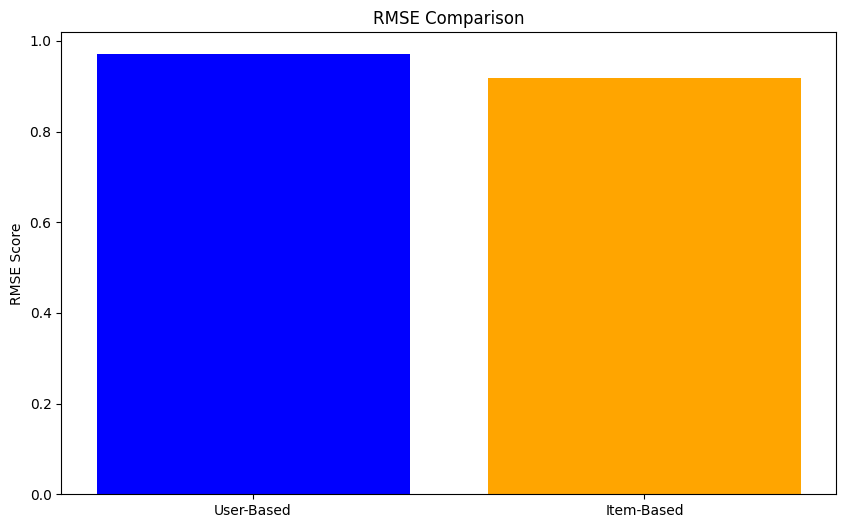

In [38]:
plt.figure(figsize=(10, 6))
models = ['User-Based', 'Item-Based']
rmse_values = [rmse_ubcf, rmse_ibcf]
plt.bar(models, rmse_values, color=['blue', 'orange'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE Score')
plt.savefig(r'C:\Users\PC\Desktop\collaborative-filtering-recommender\results\rmse_comparison.png')
plt.show()

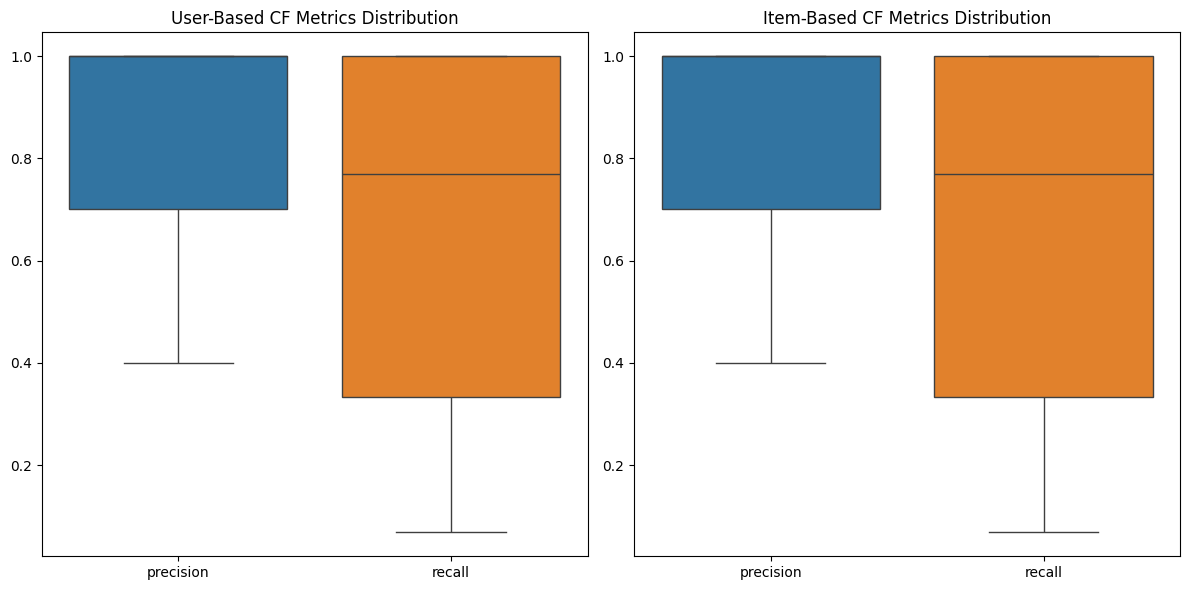

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=ubcf_metrics[['precision', 'recall']])
plt.title('User-Based CF Metrics Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(data=ibcf_metrics[['precision', 'recall']])
plt.title('Item-Based CF Metrics Distribution')
plt.tight_layout()
plt.savefig(r'C:\Users\PC\Desktop\collaborative-filtering-recommender\results\metrics_distribution.png')
plt.show()

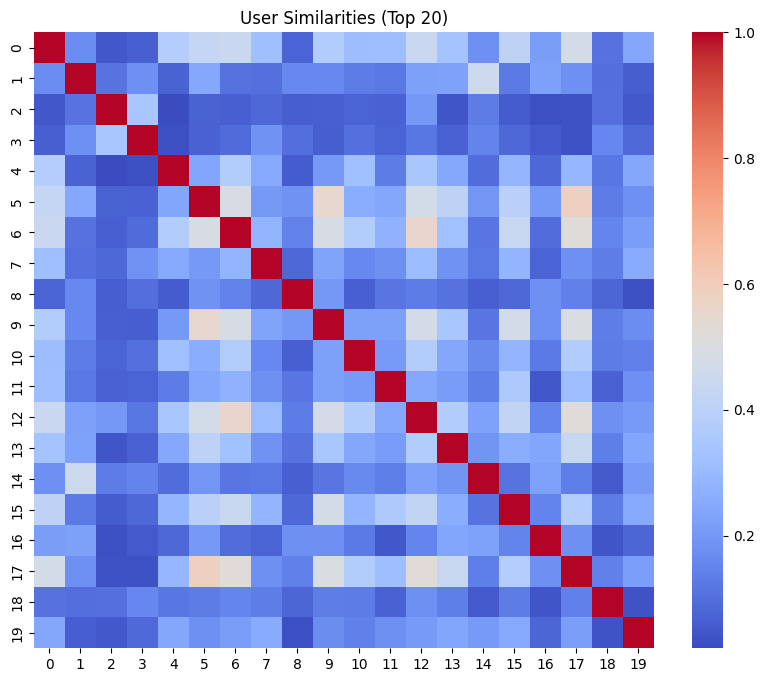

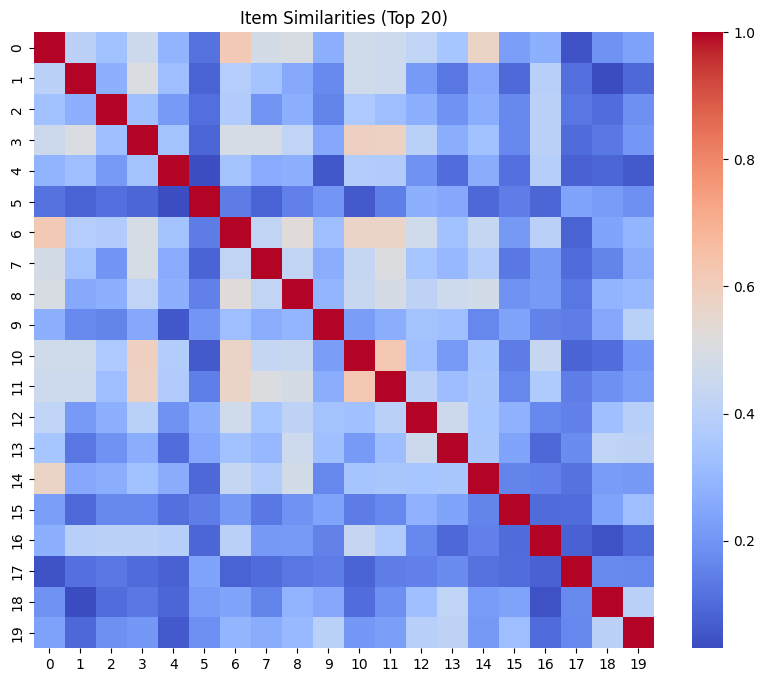

In [29]:
def plot_similarity_subset(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix[:20, :20], cmap='coolwarm')
    plt.title(title)
    plt.show()

plot_similarity_subset(ubcf_model.user_similarity_matrix_ubcf, "User Similarities (Top 20)")
plot_similarity_subset(ibcf_model.item_similarity_matrix_ibcf, "Item Similarities (Top 20)")

In [ ]:
import json
from datetime import datetime

# Create metrics dictionary
metrics_data = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "dataset": {
        "name": "MovieLens 100K",
        "num_users": user_item_matrix.shape[0],
        "num_items": user_item_matrix.shape[1],
        "test_size": len(test_ratings)
    },
    "models": {
        "user_based_cf": {
            "rmse": float(rmse_ubcf),
            "precision@10": float(ubcf_metrics['precision'].mean()),
            "recall@10": float(ubcf_metrics['recall'].mean()),
            "parameters": {
                "min_common_items": 5
            }
        },
        "item_based_cf": {
            "rmse": float(rmse_ibcf),
            "precision@10": float(ibcf_metrics['precision'].mean()),
            "recall@10": float(ibcf_metrics['recall'].mean()),
            "parameters": {
                "min_common_users": 5
            }
        }
    },
    "evaluation_notes": [
        "Metrics calculated on 20% stratified test split",
        "Precision/Recall calculated for top-10 recommendations"
    ]
}

# Save to JSON file
metrics_path = r'C:\Users\PC\Desktop\collaborative-filtering-recommender\results\evaluation_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics_data, f, indent=2)

print(f"\nEvaluation metrics saved to: {metrics_path}")


Evaluation metrics saved to: C:\Users\PC\Desktop\collaborative-filtering-recommender\results\evaluation_metrics.json


In [64]:
def generate_topn_ubcf(model, user_id, user_item_matrix, n=10):
    """User-Based CF Recommendations with Type Safety"""
    # Convert columns to integers explicitly
    all_items = user_item_matrix.columns.astype(int)
    user_rated = user_item_matrix.loc[user_id].dropna().index.astype(int)
    unrated = [i for i in all_items if i not in user_rated]
    
    preds = []
    for item_id in unrated:
        try:
            pred = model.predict_rating_ubcf(int(user_id), int(item_id))
        except:
            pred = np.nan
        if not np.isnan(pred):
            preds.append((item_id, pred))
    
    return sorted(preds, key=lambda x: x[1], reverse=True)[:n]

def generate_topn_ibcf(model, user_id, user_item_matrix, n=10):
    """Item-Based CF Recommendations with Type Safety"""
    # Convert indices to integers explicitly
    user_ratings = user_item_matrix.loc[user_id]
    unrated_items = user_ratings[user_ratings.isna()].index.astype(int)
    
    preds = []
    for item_id in unrated_items:
        try:
            pred = model.predict_rating_ibcf(int(user_id), int(item_id))
        except:
            pred = np.nan
        if not np.isnan(pred):
            preds.append((item_id, pred))
    
    return sorted(preds, key=lambda x: x[1], reverse=True)[:n]

def generate_all_recommendations(model, model_type, user_item_matrix, user_ids, n=10):
    """Generate recommendations for multiple users"""
    all_recs = []
    
    for user_id in user_ids:
        if model_type == 'ubcf':
            recs = generate_topn_ubcf(model, user_id, user_item_matrix, n)
        elif model_type == 'ibcf':
            recs = generate_topn_ibcf(model, user_id, user_item_matrix, n)
        
        for rank, (item_id, rating) in enumerate(recs, 1):
            all_recs.append({
                'user_id': user_id,
                'item_id': item_id,
                'predicted_rating': rating,
                'model_type': model_type,
                'rank': rank
            })
    
    return pd.DataFrame(all_recs)


In [65]:
user_item_matrix = pd.read_csv(
    r'C:\Users\PC\Desktop\collaborative-filtering-recommender\results\user_item_matrix.csv',
    index_col='user_id_ml'
)
test_ratings = pd.read_csv(
    r'C:\Users\PC\Desktop\collaborative-filtering-recommender\results\test_ratings.csv'
)

# 2. Initialize models
ubcf_model = UserBasedCF(min_common_items=5)
ubcf_model.fit(user_item_matrix)
ibcf_model = ItemBasedCF(min_common_users=5)
ibcf_model.fit(user_item_matrix)

# 3. Generate recommendations separately
ubcf_recs = generate_all_recommendations(
    model=ubcf_model,
    model_type='ubcf',
    user_item_matrix=user_item_matrix,
    user_ids=test_ratings['user_id_ml'].unique()[:100],  # First 100 users
    n=10
)

ibcf_recs = generate_all_recommendations(
    model=ibcf_model,
    model_type='ibcf',
    user_item_matrix=user_item_matrix,
    user_ids=test_ratings['user_id_ml'].unique()[:100],
    n=10
)

# 4. Combine and save results
combined_recs = pd.concat([ubcf_recs, ibcf_recs])
combined_recs.to_csv(
    r'C:\Users\PC\Desktop\collaborative-filtering-recommender\results\top_n_recommendations.csv',
    index=False
)

print(f"Successfully generated and saved {len(combined_recs)} recommendations")

Successfully generated and saved 1922 recommendations
